In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('~/Desktop/Projects/Text_Classification/feedback_data.csv')

In [3]:
train = pd.read_csv("~/Desktop/Projects/Text_Classification/training_set.csv")
train = train[['Tag','message']]
train = train.drop_duplicates()
train = train[train.message!=np.nan]
train = train.astype(str)

In [4]:
from io import StringIO

train['category_id'] = train['Tag'].factorize()[0] 
#because categorical variables are better represented as numbers than strings
category_id_df = train[['Tag', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Tag']].values)

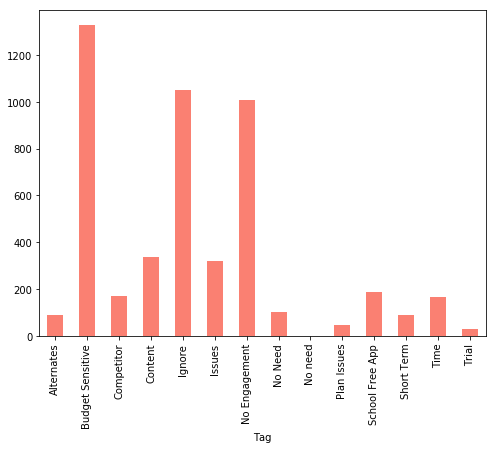

In [5]:
fig = plt.figure(figsize=(8,6)) #width and height of graph mentioned
train.groupby('Tag').message.count().plot.bar(ylim=0,color='salmon') #plotting a bar graph grouped by Tag and counting message for each
plt.show() #display the created bar graph

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Classifiers and learning algorithms cannot process text in its original form, so use bag of words model 
#(ngrams) (1,2) - will only give one word or tro word combinations agaginst a category_id
#stop-words: english stop-words are common pronouns used (to, the, a, an ....) 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                            ngram_range=(1, 2), stop_words='english') 

#feature set creation
features = tfidf.fit_transform(train['message'].values.astype('U')).toarray()
labels = train.category_id

model_name
LinearSVC                 0.664570
LogisticRegression        0.654025
MultinomialNB             0.511881
RandomForestClassifier    0.308546
Name: accuracy, dtype: float64

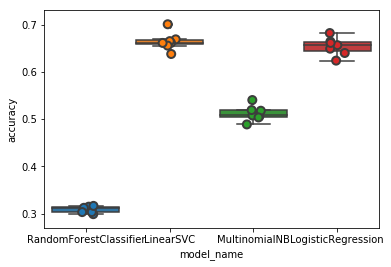

In [7]:
from sklearn.feature_selection import chi2

N = 2
for tag, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  #print("# '{}':".format(tag))
  #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    
    
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(train['message'], 
                                                    train['Tag'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)    


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(penalty='l2',multi_class='ovr',random_state=0,tol=1e-05),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 7
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.show()

#Model Results (Performance)
cv_df.groupby('model_name').accuracy.mean()

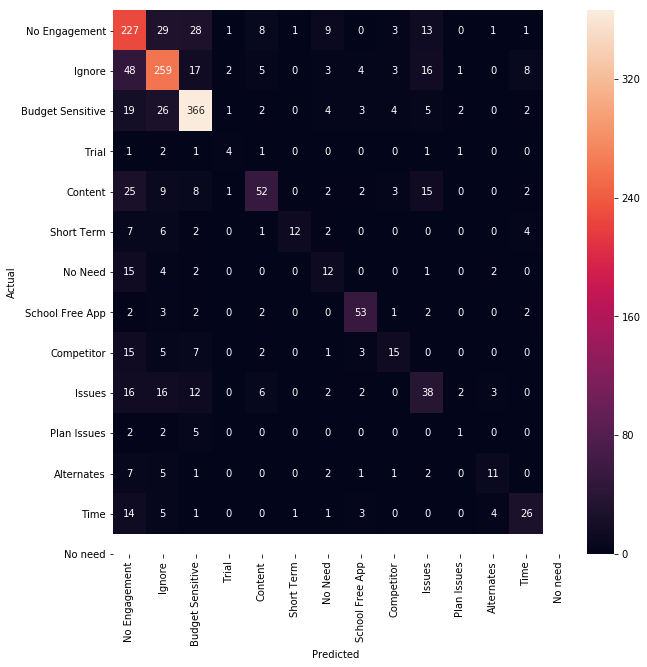

In [8]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Tag.values, yticklabels=category_id_df.Tag.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [9]:
#from IPython.display import display
#for predicted in category_id_df.category_id:
#  for actual in category_id_df.category_id:
#    if predicted != actual and conf_mat[actual, predicted] >= 10:
#      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
#      display(train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Tag', 'message']])
#      print('')

In [10]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  #print("# '{}':".format(Product))
  #print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  #print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

a = list(df.message.dropna())
texts = a
final = pd.DataFrame(columns=['message','predicted_tag'])
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
i=0
for text, predicted in zip(texts, predictions):
  final.loc[i,'message'] = format(text)
  final.loc[i,'predicted_tag'] = format(id_to_category[predicted])
  i=i+1

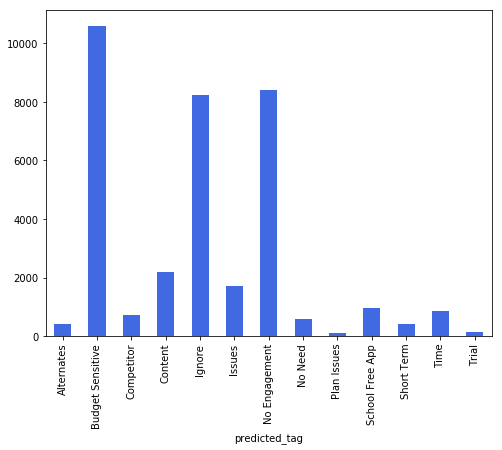

In [33]:
fig1 = plt.figure(figsize=(8,6)) #width and height of graph mentioned
final.groupby('predicted_tag').message.count().plot.bar(ylim=0,color='royalblue') #plotting a bar graph grouped by Tag and counting message for each
#plt.show() #display the created bar graph

In [12]:
final.to_csv("~/Desktop/Projects/Text_Classification/final_tagging.csv",index=False)